# Correlation analysis

In this notebook we cover the steps for conducting the correlation analysis.

## Pre-requisities

* The final data has been harmonized
    * Grouped per sector
    * Sentiment analysis has been done
* Requirements installed: `pip install -f requirements.txt`

## Step 1

The first step is to import dependencies and load the data into `df` variable. We also create a new column called `crime_density` which accounts the area that the sector covers, and the count of crimes within that area.



In [1]:
import pandas as pd
from scipy.stats import pearsonr, normaltest
import matplotlib.pyplot as plt
# Display images in the notebook
%matplotlib inline

FINAL_DATA_IN = 'datasets/final_data_avg.csv'
CRIME_DENSITY = 'crime_density'

df = pd.read_csv(FINAL_DATA_IN)

df[CRIME_DENSITY] = df.apply(
    lambda x: x['crime_count'] / x['area'],
    axis = 1
)


## Step 2

In this step, we simply plot the features that we have extracted using NLP methods from the Hotel data. The features are plotted with the `crime_density` variable.

Explaining variable: `sentiment_crime`, `sentiment_positive`, `sentiment_unsafe`
Explained variable: `crime_density`

Basically the scatter plots should display somewhat visible line in case there were correlation between the variables (e.g. if `sentiment_crime` can explain the change in `crime_density`).


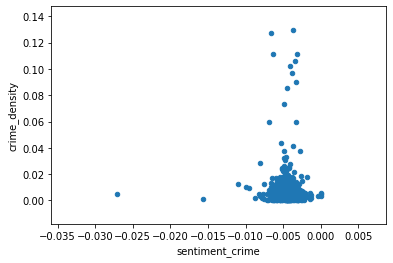

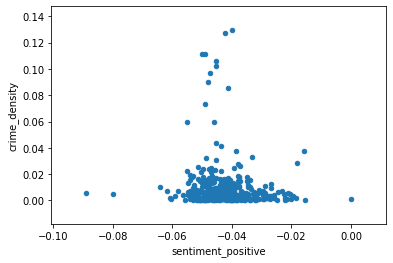

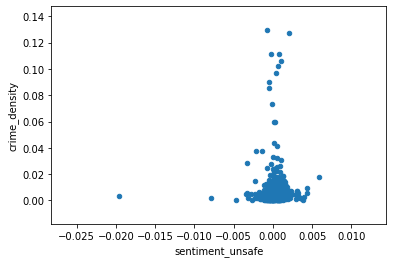

In [2]:

sentiments = [
    'sentiment_crime',
    'sentiment_positive',
    'sentiment_unsafe'
]

for sentiment in sentiments:
    df.plot(
        x = sentiment,          # Explaining variable
        y = CRIME_DENSITY,      # Explained variable
        kind = 'scatter'
    )



## Step 3

The next step is to investigate further the [correlation](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/) between variables in the dataset.

As we are looking mostly at metric variables, we have several options:

* Pearson's product-moment correlation method
* Spearman rank-order correlation

Pandas `DataFrame` [supports](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) also Kendall's method, but we don't have experience on that right now.

There are some tests that we should consider before choosing the method of correlation test. Generally, the Pearson's method is the choice when the data is normally distributed on all variables. If it's not, then we should consider Spearman.



In [3]:
# Get numeric variables into a list
variables = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['int64', 'float64']]
dropped = variables.pop(0) # Drop the 'Unnamed: 0' column
assert dropped == 'Unnamed: 0', 'Expected to drop column "Unnamed: 0" but dropped: {}'.format(dropped)

def values_normally_distributed(data: pd.DataFrame, variable: str) -> int:
    """Test if the values of given variable is normally distributed.

    Arguments:

        data {pd.DataFrame} -- The data

        variable {str} -- The variable to test

    Returns:

        {int} -- Value describing the result and it's significance. 0 means
        that null hypothesis can't be rejected (values aren't normally
        distributed). 1 - 3 means that values are normally distributed, and
        higher value means higher statistical significance.
    """
    # p = 2-sided chi squared probability for the hypothesis test
    k2, p = normaltest(data[variable])

    # if p < 0.05, null hypothesis can be rejected and the result is statistically almost significant
    # if p < 0.01, -||- and the result is statistically significant
    # if p < 0.001, -||- and the result is statistically extremely significant
    if p < 1e-3:
        return 3
    elif p < 1e-2:
        return 2
    elif p < 5e-2:
        return 1
    else:
        return 0

values = {}
for variable in variables:
    values[variable] = values_normally_distributed(df, variable)

smallest = min(values, key=values.get) # type: str

print('Smallest significance on variable {} with result {}'.format(smallest, values[smallest]))

if values[smallest] == 0:
    print('The null hypothesis can\'t be rejected on all variables, hence Spearman\'s method')
else:
    print('The null hypothesis can be rejected on all variables, hence Pearson\'s method')


Smallest significance on variable review_count with result 3
The null hypothesis can be rejected on all variables, hence Pearson's method


As it can be seen from the results, the data is normally distributed. Thus, we should use Pearson's method for measuring correlation coeffecients.

This regression analysis is trying to find correlation between two (or more) variables. Logically, the correlation between variables can be either positive or negative. The intepretation of correlation goes somewhat like this:

| Value range   | Intepretation                                     |
|---------------|---------------------------------------------------|
| 0.6 - 1.0     | (Strong) Positive correlation                     |
| 0.4 - 0.59    | Moderate positive correlation                     |
| 0.2 - 0.39    | Weak positive correlation                         |
| -0.19 - 0.19  | Really weak or no (pos/neg) correlation           |
| -0.2 - -0.39  | Weak negative correlation                         |
| -0.4 - -0.59  | Moderate negative correlation                     |
| -0.6 - -1.0   | (Strong) Negative correlation                     |



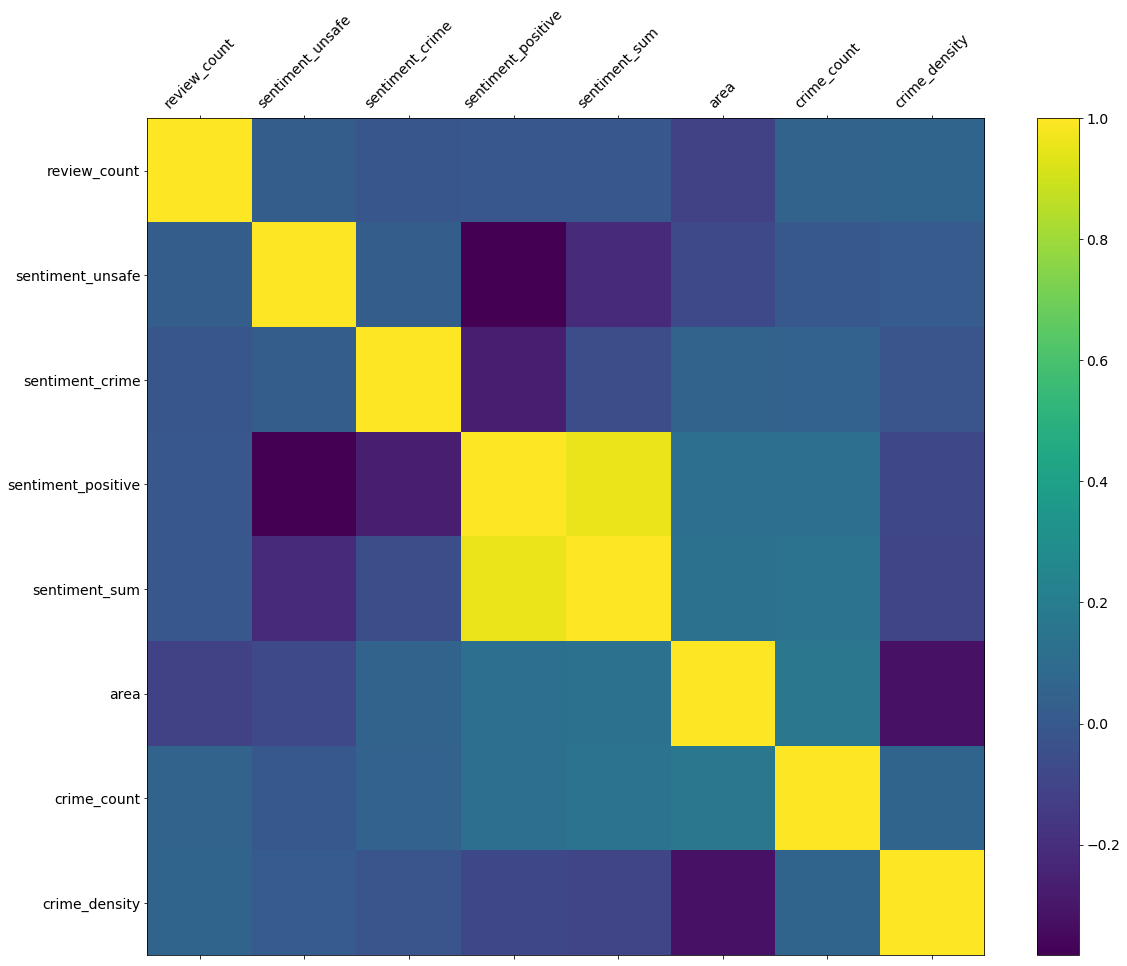


Correlations against crime_density:

review_count          0.063594
sentiment_unsafe      0.017094
sentiment_crime      -0.020057
sentiment_positive   -0.084109
sentiment_sum        -0.093748
area                 -0.314294
crime_count           0.064479
crime_density         1.000000
Name: crime_density, dtype: float64


In [4]:
# Pearson's method for normally distributed data
df_var = df[variables]
correlations = df_var.corr(method = 'pearson')

f = plt.figure(figsize = (19, 15))
plt.matshow(correlations, fignum = f.number)
plt.xticks(range(df_var.shape[1]), labels = df_var.columns, fontsize = 14, rotation = 45)
plt.yticks(range(df_var.shape[1]), labels = df_var.columns, fontsize = 14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.show()

print('\nCorrelations against {}:\n'.format(CRIME_DENSITY))
print(correlations[CRIME_DENSITY])

## Step 4

The last step is the interpretention of results. In this step, we focus at the (explained) variable `crime_density`, which describes the amount of crimes per area (m^2). The goal is to find an explaining variable, which has correlation with the `crime_density`. As we have extracted several variables using NLP methods (all starting with `sentiment_`), we are particularly interested in those variables as explaining variables.

As it can be seen from the previous step, none of the extracted features (starting with `sentiment_`) has correlation with the crime density. The variable `area` gives the highest correlation with `crime_density` (-0.31), whereas all others are between [-0.1, 0.1]. The weak negative correlation between `crime_density` and `area` can be easily explained; when the area size grows, the crime density drops. The usage of post codes in area division affects also to this; areas in the city that are densely populated tend to be divided into smaller post code areas than areas that are sparsely populated.

Thus, we can conclude that based on methods in this experiment, it's not possible to use hotel review data for sensing crime. However, we can't generalize these results as we have limited set of data and limited geographical area.